# Iniciar Sessão Spark

import os
## Set up environment variables
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-21'
os.environ['SPARK_HOME'] = r'C:\Users\kawda\Downloads\spark-3.5.4-bin-hadoop3\spark-3.5.4-bin-hadoop3'

## Initialize a Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
	.master("local[*]") \
	.config("spark.executor.memory", "8g") \
	.config("spark.driver.memory", "8g") \
	.getOrCreate()

## Verify the Spark session
spark)

# Imports

from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Summarizer
from pyspark.sql.types import DoubleType, IntegerType, StringType, NumericType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, when, isnan, lit, approx_count_distinct
from sklearn.preprocessing import StandardScaler
import numpy as np

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Dados

In [166]:
# Abrir os dados disponíveis sobre o titanic
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_survived = pd.read_csv("gender_submission.csv")

# Display the first few rows of each dataframe
df_test.head()
df_train.head()
df_survived.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [167]:
# Verificar os dados
lista_spec = ['PassengerId', 'Survived']
abt_00 = df_train.drop(columns=lista_spec)

abt_00.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [168]:
# Extrair títulos usando expressão regular
abt_00['Titulo'] = abt_00['Name'].str.extract(r' (Mr\.|Miss\.|Mrs\.|Dr\.) ')
abt_00.drop(axis=1, columns='Name', inplace=True)
abt_00.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.


# Data Preparation

## Tratamento inicial padrão (Alta porcentagem de nulos, Variáveis constantes, Missings)

In [169]:
import pandas as pd
from scipy import stats

def get_metadata(dataframe):
	# Coleta de metadados básicos
	metadata = pd.DataFrame({
		'nome_variavel': dataframe.columns,
		'tipo': dataframe.dtypes,
		'qt_nulos': dataframe.isnull().sum(),
		'percent_nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
		'cardinalidade': dataframe.nunique(),
	})

	# Função para testar normalidade usando o teste de Shapiro-Wilk
	def test_normality(series, alpha=0.05):
		if series.dtype in ["float64", "int64", "int32"]:
			statistic, p_value = stats.shapiro(series.dropna())  # dropping NA values for the test
			return p_value > alpha
		else:
			return None  # Return None for non-numeric data types

	# Aplicando teste de normalidade
	metadata["fl_normal"] = dataframe.apply(test_normality)

	metadata = metadata.sort_values(by='percent_nulos', ascending=False)
	metadata = metadata.reset_index(drop=True)

	return metadata

# Apply the function to the dataframe
metadados = get_metadata(abt_00)
metadados.head()

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,fl_normal
0,Cabin,object,687,77.10,147,None
1,Age,float64,177,19.87,88,False
2,Titulo,object,60,6.73,4,None
3,Embarked,object,2,0.22,3,None
4,Pclass,int64,0,0.00,3,False


In [170]:
def preprocess_dataframe(df):
	# Drop columns with >80% missing values
	total_count = len(df)
	columns_to_drop = [col for col in df.columns if df[col].isnull().sum() / total_count > 0.8]
	df = df.drop(columns=columns_to_drop)
	
	# Replace missing values
	for col_name in df.columns:
		data_type = df[col_name].dtype
		
		if np.issubdtype(data_type, np.number):
			mean_value = df[col_name].mean()
			df[col_name] = df[col_name].fillna(mean_value)
		elif data_type == object:
			df[col_name] = df[col_name].fillna("Desconhecido")
	
	# Drop columns with variance equals to 0
	numeric_columns = df.select_dtypes(include=[np.number]).columns
	variances = df[numeric_columns].var()
	columns_to_drop = variances[variances == 0].index.tolist()
	df = df.drop(columns=columns_to_drop)
	
	return df

# Apply the function to the dataframe
abt_01 = preprocess_dataframe(abt_00)
abt_01.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,3,male,22.0,1,0,A/5 21171,7.2500,Desconhecido,S,Mr.
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Desconhecido,S,Miss.
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,3,male,35.0,0,0,373450,8.0500,Desconhecido,S,Mr.


## Tratamento de variáveis numéricas (Padronização)

In [171]:
# Instanciando o scaler
scaler = StandardScaler()

# Selecionando colunas numéricas
numeric_cols = abt_01.select_dtypes(include=['float64', 'int64','int32']).columns

# Aplicando a normalização
abt_01[numeric_cols] = scaler.fit_transform(abt_01[numeric_cols])

# Show the result
abt_01.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,0.827377,male,-0.592481,0.432793,-0.473674,A/5 21171,-0.502445,Desconhecido,S,Mr.
1,-1.566107,female,0.638789,0.432793,-0.473674,PC 17599,0.786845,C85,C,Mrs.
2,0.827377,female,-0.284663,-0.474545,-0.473674,STON/O2. 3101282,-0.488854,Desconhecido,S,Miss.
3,-1.566107,female,0.407926,0.432793,-0.473674,113803,0.420730,C123,S,Mrs.
4,0.827377,male,0.407926,-0.474545,-0.473674,373450,-0.486337,Desconhecido,S,Mr.


## Tratamento de variáveis categóricas

### Baixa Cardinalidade (Dummy)

In [172]:
card_cutoff = 5
df_categ_onehot = metadados[(metadados['cardinalidade'] <= card_cutoff) & (metadados['tipo'] == 'object')]
lista_onehot = list(df_categ_onehot.nome_variavel.values)
print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(abt_01[lista_onehot])

# Criando um DataFrame com as colunas codificadas, mantendo o índice original
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=abt_01.index)

# Concatenando o DataFrame codificado com o DataFrame original
abt_01 = pd.concat([abt_01.drop(lista_onehot, axis=1), encoded_df], axis=1)

abt_01.head()


Lista de vars para OneHot Encoding:  ['Titulo', 'Embarked', 'Sex']


,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male
0,0.827377,-0.592481,0.432793,-0.473674,A/5 21171,-0.502445,Desconhecido,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,PC 17599,0.786845,C85,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,STON/O2. 3101282,-0.488854,Desconhecido,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.566107,0.407926,0.432793,-0.473674,113803,0.420730,C123,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.827377,0.407926,-0.474545,-0.473674,373450,-0.486337,Desconhecido,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


### Alta Cardinalidade (Label Encoding)

In [173]:
card_cutoff = 5
df_categ_labelenc = metadados[(metadados['cardinalidade'] > card_cutoff) & (metadados['tipo'] == 'object')]
lista_lenc = list(df_categ_labelenc.nome_variavel.values)
print('Lista de vars para Label Encoding: ',lista_lenc)

# Aplicando LabelEncoder nas colunas desejadas
for col in lista_lenc:
    encoder = LabelEncoder()
    abt_01[col] = encoder.fit_transform(abt_01[col])

abt_01.head()


Lista de vars para Label Encoding:  ['Cabin', 'Ticket']


,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


### Juntar os dados sensíveis

In [174]:
# Inner join usando o índice
abt_model = pd.merge(abt_01, df_train[['Survived']], left_index=True, right_index=True, how='inner')
abt_model.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male,Survived
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


# Métodos de seleção de variáveis

## Feature Importance

In [175]:
# Cópia para FI
abt_fi = abt_model.copy()
abt_fi.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male,Survived
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


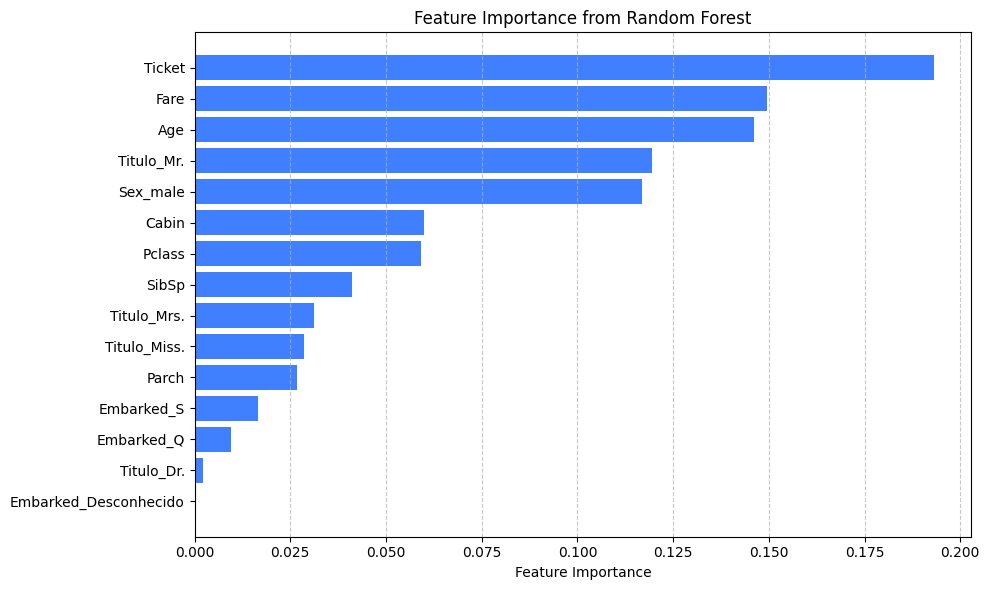

In [176]:
X = abt_fi.drop(axis=1, columns='Survived')
y = abt_fi.Survived

# Treinar modelo com algoritmo Random Forest (Calma, não precisa focar no modelo neste momento)
clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.6

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
selected_features
# Visualizando a importância das variáveis em barras horizontais

plt.figure(figsize=(10, 6))
sorted_idx = feature_importances.argsort()

plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color=(0.25, 0.5, 1))  # tom de azul claro
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [177]:
# Mantendo somente as variáveis selecionadas na ABT
abt_02 = abt_fi[selected_features + ['Survived']]

abt_02.head()

,Age,Ticket,Fare,Titulo_Mr.,Sex_male,Survived
0,-0.592481,523,-0.502445,1.0,1.0,0
1,0.638789,596,0.786845,0.0,0.0,1
2,-0.284663,669,-0.488854,0.0,0.0,1
3,0.407926,49,0.420730,0.0,0.0,1
4,0.407926,472,-0.486337,1.0,1.0,0


## Recursive Feature Elimination (RFE)

In [178]:
# Cópia para RFE
abt_rfe = abt_model.copy()

## Boruta

In [179]:
# Cópia para Boruta
abt_boruta = abt_model.copy()

## Pearson Correlation

In [180]:
# Cópia para Pearson
abt_pearson = abt_model.copy()

## Corte por IV

In [181]:
# Cópia para IV
abt_iv = abt_model.copy()

## PCA + IV

In [182]:
# Cópia para PCA+IV
abt_pca_iv = abt_model.copy()